In [1]:
# NBA Game Data Analysis

## This notebook analyzes clean NBA game data from the 2017-18 through 2023-24 seasons to identify patterns that will inform our prediction model. The data has been filtered to include only regular season and playoff games for the 30 official NBA teams.

## Data Loading and Overview
    
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from datetime import datetime

# Set visualization styles for better-looking plots
plt.style.use('fivethirtyeight')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Find and load the most recent cleaned game data file
clean_files = glob.glob('../data/processed/nba_games_clean_*.csv')
latest_file = max(clean_files, key=os.path.getctime)
print(f"Loading clean NBA data from: {latest_file}")

# Load the data
games_df = pd.read_csv(latest_file)

# Convert date column to datetime for time-based analysis
games_df['GAME_DATE'] = pd.to_datetime(games_df['GAME_DATE'])

# Display basic information about the dataset
print(f"Dataset shape: {games_df.shape} (rows, columns)")
print(f"Seasons covered: {sorted(games_df['SEASON'].unique())}")
print(f"Date range: {games_df['GAME_DATE'].min().strftime('%Y-%m-%d')} to {games_df['GAME_DATE'].max().strftime('%Y-%m-%d')}")
print(f"Unique games: {games_df['GAME_ID'].nunique()}")
print(f"Unique teams: {games_df['TEAM_NAME'].nunique()}")

# Show the first few rows to understand data structure
games_df.head()

## Data Structure and Preparation
# Before diving into analysis, first lets understand the data structure and prepare it for exploration. Each row represents one team's -
# in a game, with two rows (home and away team perspectives) for most games>


Loading clean NBA data from: ../data/processed/nba_games_clean_20250318_152105.csv
Dataset shape: (17748, 31) (rows, columns)
Seasons covered: ['2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24']
Date range: 2017-10-17 to 2024-06-17
Unique games: 8874
Unique teams: 30


,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,SEASON,GAME_TYPE,SEASON_TYPE
0,22017,1610612753,ORL,Orlando Magic,21701222,2018-04-11,ORL vs. WAS,W,239,101,...,42,20,6,7,16,27,9.0,2017-18,2,Regular Season
1,22017,1610612755,PHI,Philadelphia 76ers,21701223,2018-04-11,PHI vs. MIL,W,240,130,...,57,35,15,7,12,17,35.0,2017-18,2,Regular Season
2,22017,1610612749,MIL,Milwaukee Bucks,21701223,2018-04-11,MIL @ PHI,L,240,95,...,43,22,6,5,20,17,-35.0,2017-18,2,Regular Season
3,22017,1610612751,BKN,Brooklyn Nets,21701219,2018-04-11,BKN @ BOS,L,240,97,...,44,27,10,6,15,12,-13.0,2017-18,2,Regular Season
4,22017,1610612752,NYK,New York Knicks,21701220,2018-04-11,NYK @ CLE,W,239,110,...,39,30,10,3,15,22,12.0,2017-18,2,Regular Season


In [2]:

# Examine the columns to understand available data
print("Column names and data types:")
games_df.dtypes

# Check for missing values in each column
missing_values = games_df.isnull().sum()
print("\nMissing values by column:")
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values found")

# Create indicators for key attributes
# 1. Create home/away indicator based on matchup
games_df['HOME'] = games_df['MATCHUP'].str.contains('vs').astype(int)

# 2. Add win indicator for easier analysis
games_df['WIN'] = (games_df['WL'] == 'W').astype(int)

# 3. Extract season year (first year of season) for easier grouping
games_df['SEASON_YEAR'] = games_df['SEASON'].str.split('-').str[0].astype(int)

# 4. Add playoff indicator if possible (based on game ID structure)
games_df['PLAYOFF'] = games_df['GAME_ID'].astype(str).str.startswith('4').astype(int)

# Display data distribution across seasons
season_counts = games_df.groupby(['SEASON', 'PLAYOFF'])['GAME_ID'].nunique().unstack(fill_value=0)
season_counts.columns = ['Regular Season', 'Playoffs']
season_counts['Total'] = season_counts.sum(axis=1)

print("\nGames per season:")
print(season_counts)

# Check team frequency to ensure balanced representation
team_counts = games_df['TEAM_NAME'].value_counts()

print(f"\nMost frequent team: {team_counts.index[0]} with {team_counts.iloc[0]} games")
print(f"Least frequent team: {team_counts.index[-1]} with {team_counts.iloc[-1]} games")

Column names and data types:

Missing values by column:
FT_PCT    1
dtype: int64

Games per season:
         Regular Season  Playoffs  Total
SEASON                                  
2017-18            1230        82   1312
2018-19            1230        82   1312
2019-20            1059        83   1142
2020-21            1080        85   1165
2021-22            1230        87   1317
2022-23            1230        84   1314
2023-24            1230        82   1312

Most frequent team: Boston Celtics with 667 games
Least frequent team: Charlotte Hornets with 547 games


In [3]:
## Home Court Advantage Analysis

# Home court advantage is one of the most important factors in basketball prediction. Let's analyze its impact on winning probability and scoring.

Home teams win 56.40% of games
Away teams win 43.60% of games
Home court advantage: 12.80 percentage points


/var/folders/4p/k3p3mnfx6zx1711_f5mhdlcr0000gn/T/ipykernel_23282/522497221.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hca_by_season = games_df.groupby('SEASON').apply(


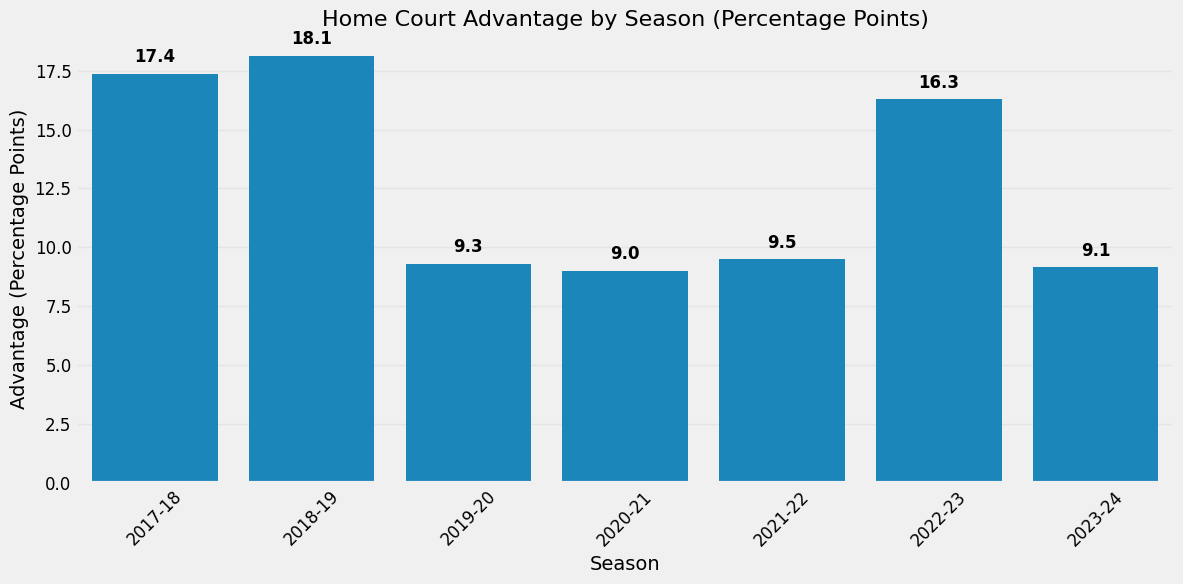


Home teams score 112.38 points on average
Away teams score 110.21 points on average
Home scoring advantage: 2.17 points


<Figure size 1400x700 with 0 Axes>

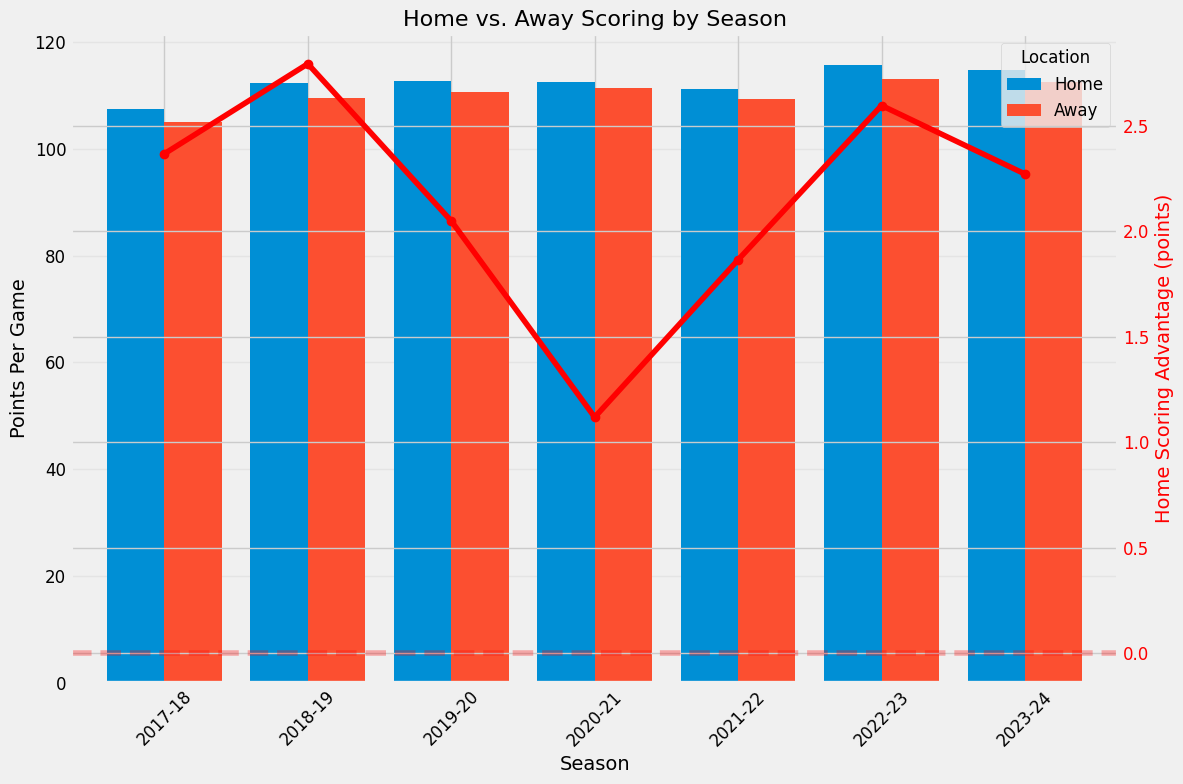

In [4]:
# Calculate overall home court advantage
home_games = games_df[games_df['HOME'] == 1]
away_games = games_df[games_df['HOME'] == 0]

home_win_pct = home_games['WIN'].mean() * 100
away_win_pct = away_games['WIN'].mean() * 100
home_advantage = home_win_pct - away_win_pct

print(f"Home teams win {home_win_pct:.2f}% of games")
print(f"Away teams win {away_win_pct:.2f}% of games")
print(f"Home court advantage: {home_advantage:.2f} percentage points")

# Home court advantage by season
plt.figure(figsize=(12, 6))
hca_by_season = games_df.groupby('SEASON').apply(
    lambda x: x[x['HOME'] == 1]['WIN'].mean() - x[x['HOME'] == 0]['WIN'].mean()
) * 100

ax = sns.barplot(x=hca_by_season.index, y=hca_by_season.values)
plt.title('Home Court Advantage by Season (Percentage Points)', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Advantage (Percentage Points)', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)

# Add value labels on the bars
for i, v in enumerate(hca_by_season):
    plt.text(i, v + 0.5, f"{v:.1f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Scoring differences home vs. away
home_pts = home_games['PTS'].mean()
away_pts = away_games['PTS'].mean()
pts_diff = home_pts - away_pts

print(f"\nHome teams score {home_pts:.2f} points on average")
print(f"Away teams score {away_pts:.2f} points on average")
print(f"Home scoring advantage: {pts_diff:.2f} points")

# Visualize the home court impact on points per game by season
plt.figure(figsize=(14, 7))
season_pts = games_df.groupby(['SEASON', 'HOME'])['PTS'].mean().unstack()
season_pts.columns = ['Away', 'Home']
season_pts['Difference'] = season_pts['Home'] - season_pts['Away']

# Plot the points
season_pts[['Home', 'Away']].plot(kind='bar', width=0.8)
plt.title('Home vs. Away Scoring by Season', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Points Per Game', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.legend(title='Location')

# Add a line for the point differential
ax2 = plt.twinx()
season_pts['Difference'].plot(kind='line', marker='o', color='red', ax=ax2)
ax2.set_ylabel('Home Scoring Advantage (points)', color='red', fontsize=14)
ax2.tick_params(axis='y', colors='red')
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
## Team Performance Analysis

# Understanding how teams perform over time provides essential context for prediction. Let's analyze team win rates, scoring patterns, and trends over multiple seasons.

Overall Team Performance (2017-2024):


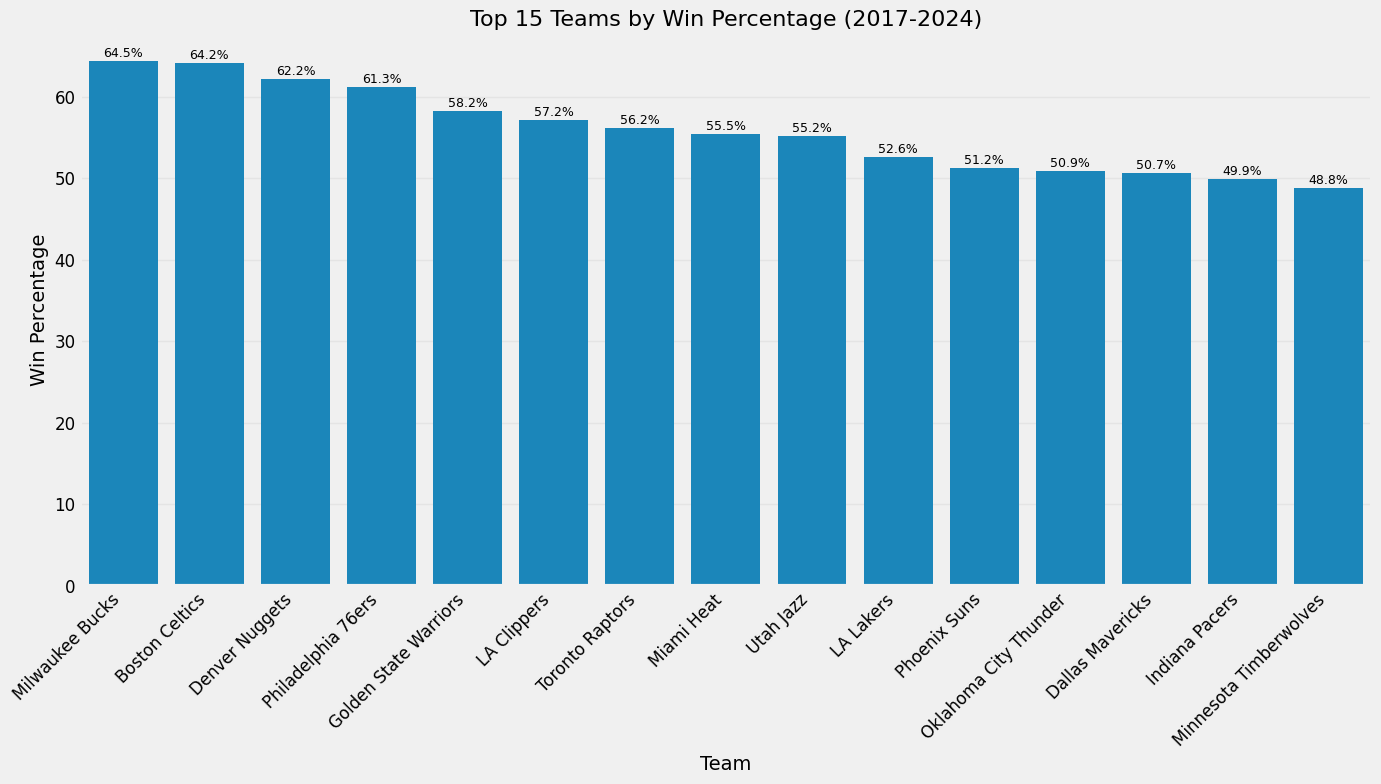

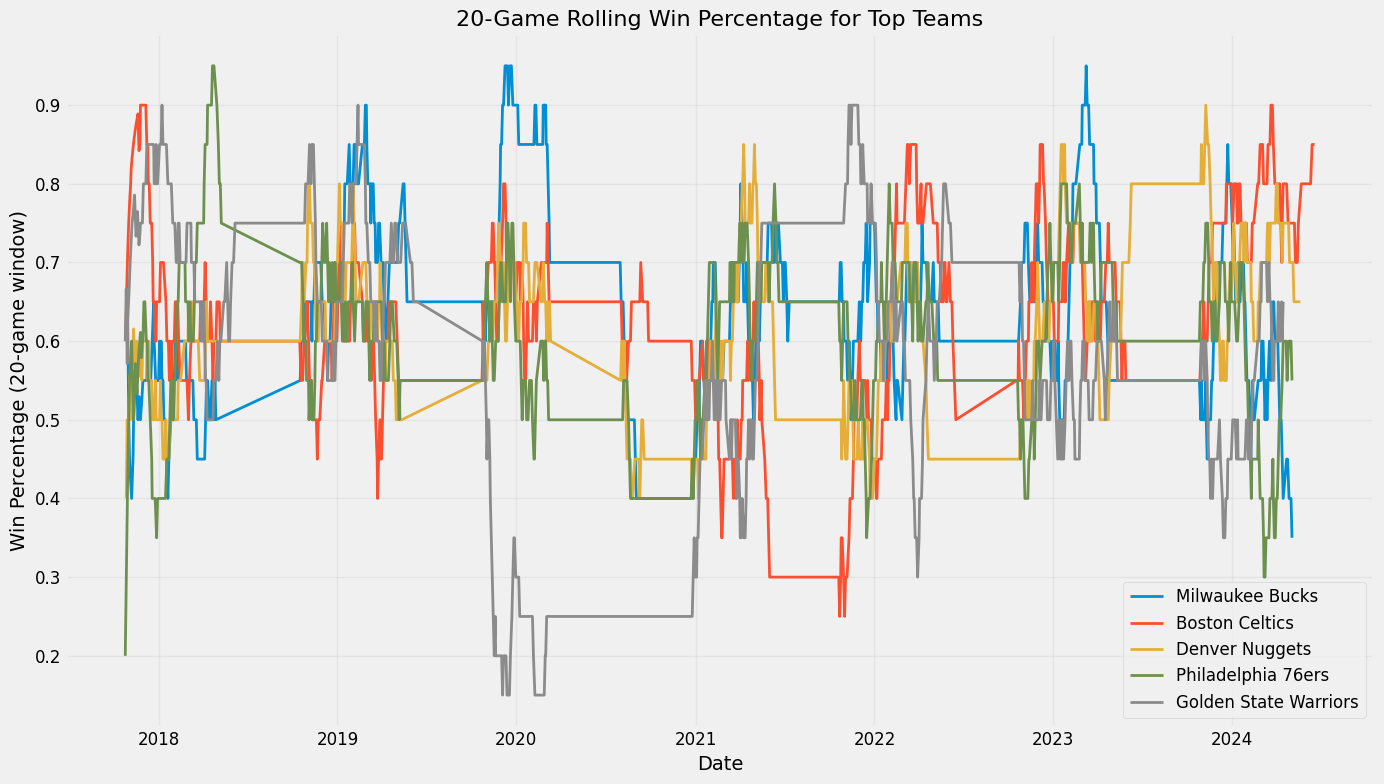

In [6]:
# Calculate overall team performance metrics
team_stats = games_df.groupby('TEAM_NAME').agg({
    'WIN': 'mean',
    'PTS': 'mean',
    'PLUS_MINUS': 'mean',
    'GAME_ID': 'count'
}).reset_index()

team_stats = team_stats.rename(columns={
    'WIN': 'WIN_PCT', 
    'PTS': 'PPG',
    'PLUS_MINUS': 'AVG_POINT_DIFF',
    'GAME_ID': 'GAMES_PLAYED'
})

team_stats['WIN_PCT'] = team_stats['WIN_PCT'] * 100  # Convert to percentage

# Sort by win percentage for display
team_stats = team_stats.sort_values('WIN_PCT', ascending=False)

print("Overall Team Performance (2017-2024):")
team_stats.head(10)

# Visualize team win percentages
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='TEAM_NAME', y='WIN_PCT', data=team_stats.head(15))
plt.title('Top 15 Teams by Win Percentage (2017-2024)', fontsize=16)
plt.xlabel('Team', fontsize=14)
plt.ylabel('Win Percentage', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')

# Add value labels
for i, v in enumerate(team_stats['WIN_PCT'].head(15)):
    ax.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Analyze top teams' performance over time
top_teams = team_stats.head(5)['TEAM_NAME'].tolist()

# Create a function to calculate rolling win percentage
def calculate_rolling_win_pct(team_data, window=20):
    """Calculate rolling win percentage for a team with the specified window"""
    # Sort by date
    team_data = team_data.sort_values('GAME_DATE')
    
    # Calculate rolling win percentage
    team_data['ROLLING_WIN_PCT'] = team_data['WIN'].rolling(window=window, min_periods=5).mean()
    
    return team_data

# Calculate rolling win percentage for top teams
plt.figure(figsize=(14, 8))

for team in top_teams:
    team_data = games_df[games_df['TEAM_NAME'] == team].copy()
    team_data = calculate_rolling_win_pct(team_data, window=20)
    plt.plot(team_data['GAME_DATE'], team_data['ROLLING_WIN_PCT'], label=team, linewidth=2)

plt.title('20-Game Rolling Win Percentage for Top Teams', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Win Percentage (20-game window)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
## Point Differential Analysis

# Point differential is often a stronger predictor of future performance than simple win-loss records. Let's analyze how point margins relate to team success.

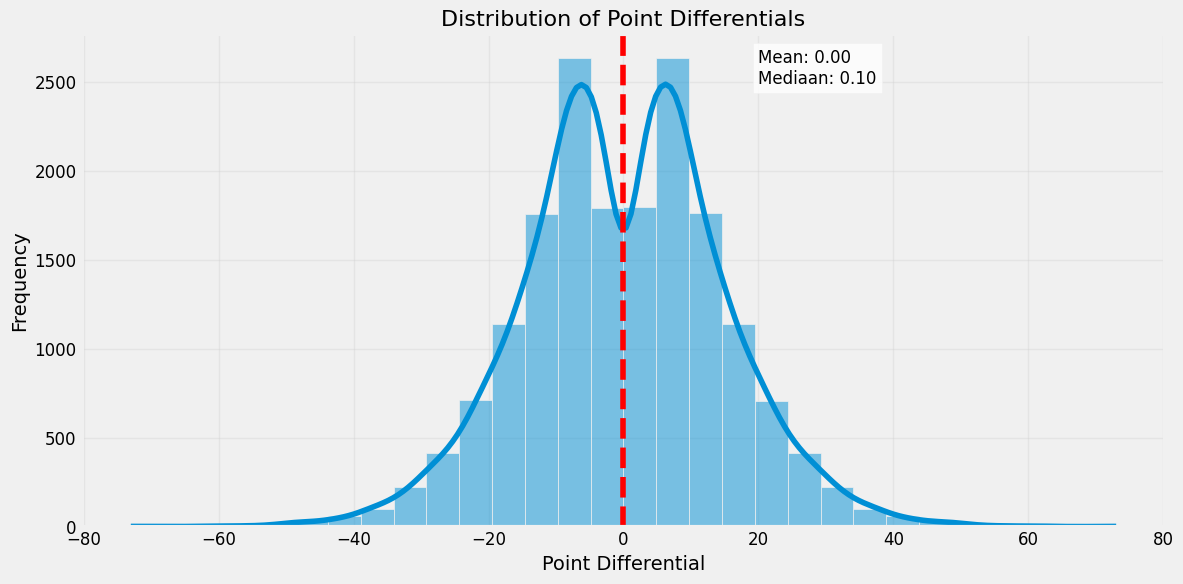

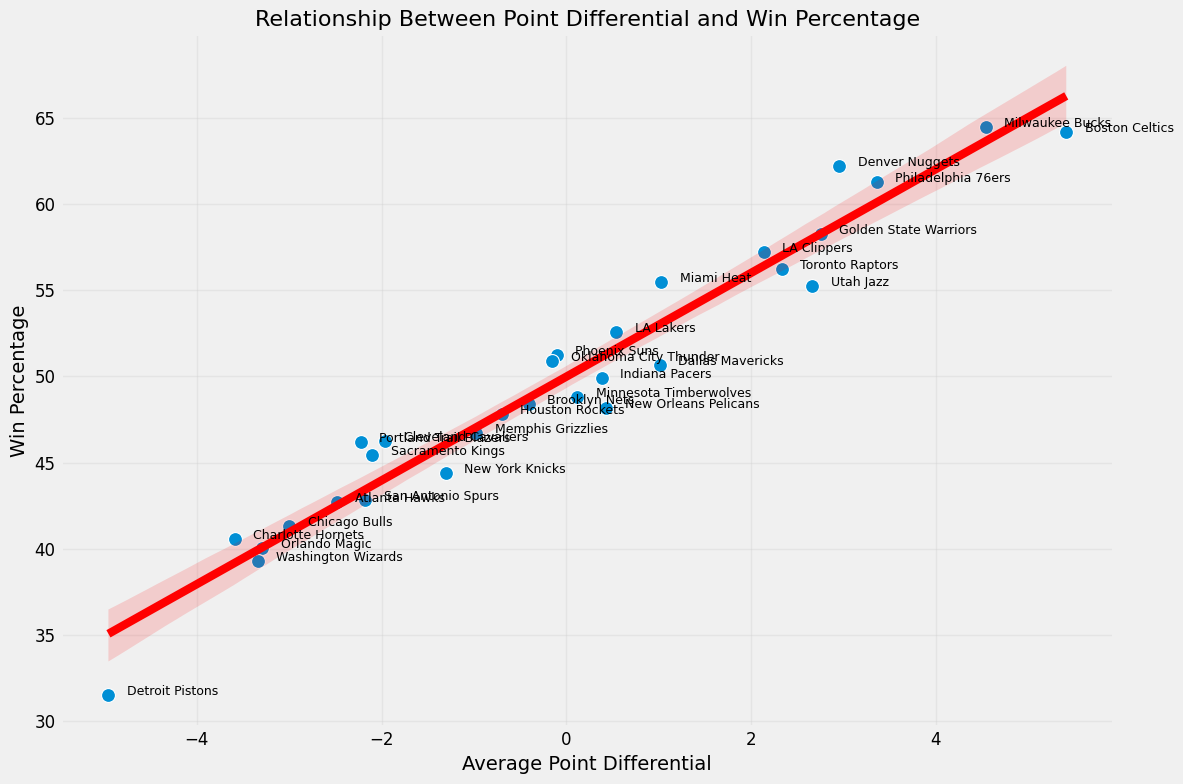

Correlation between average point differential and win percentage: 0.975


In [8]:
# Analyze distribution of point differentials
plt.figure(figsize=(12, 6))
sns.histplot(games_df['PLUS_MINUS'], kde=True, bins=30)
plt.title('Distribution of Point Differentials', fontsize=16)
plt.xlabel('Point Differential', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(alpha=0.3)
plt.axvline(x=0, color='red', linestyle='--')

# Annotate with key statistics
mean_diff = games_df['PLUS_MINUS'].mean()
median_diff = games_df['PLUS_MINUS'].median()
plt.text(20, plt.gca().get_ylim()[1]*0.9, f"Mean: {mean_diff:.2f}\nMediaan: {median_diff:.2f}", 
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Relationship between point differential and win percentage
# Calculate average point differential by team
team_diff = games_df.groupby('TEAM_NAME')[['PLUS_MINUS', 'WIN']].mean()
team_diff['WIN_PCT'] = team_diff['WIN'] * 100
team_diff = team_diff.sort_values('PLUS_MINUS', ascending=False)

# Create scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PLUS_MINUS', y='WIN_PCT', data=team_diff, s=100)

# Add team labels to points
for i, row in team_diff.iterrows():
    plt.text(row['PLUS_MINUS']+0.2, row['WIN_PCT'], i, fontsize=9)
    
# Add regression line
sns.regplot(x='PLUS_MINUS', y='WIN_PCT', data=team_diff, scatter=False, line_kws={"color":"red"})

plt.title('Relationship Between Point Differential and Win Percentage', fontsize=16)
plt.xlabel('Average Point Differential', fontsize=14)
plt.ylabel('Win Percentage', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate correlation coefficient
correlation = team_diff['PLUS_MINUS'].corr(team_diff['WIN_PCT'])
print(f"Correlation between average point differential and win percentage: {correlation:.3f}")

In [9]:
## Game Context Analysis

# Game context factors such as rest days, back-to-backs, and travel can significantly impact team performance. Let's analyze how these factors affect outcomes.

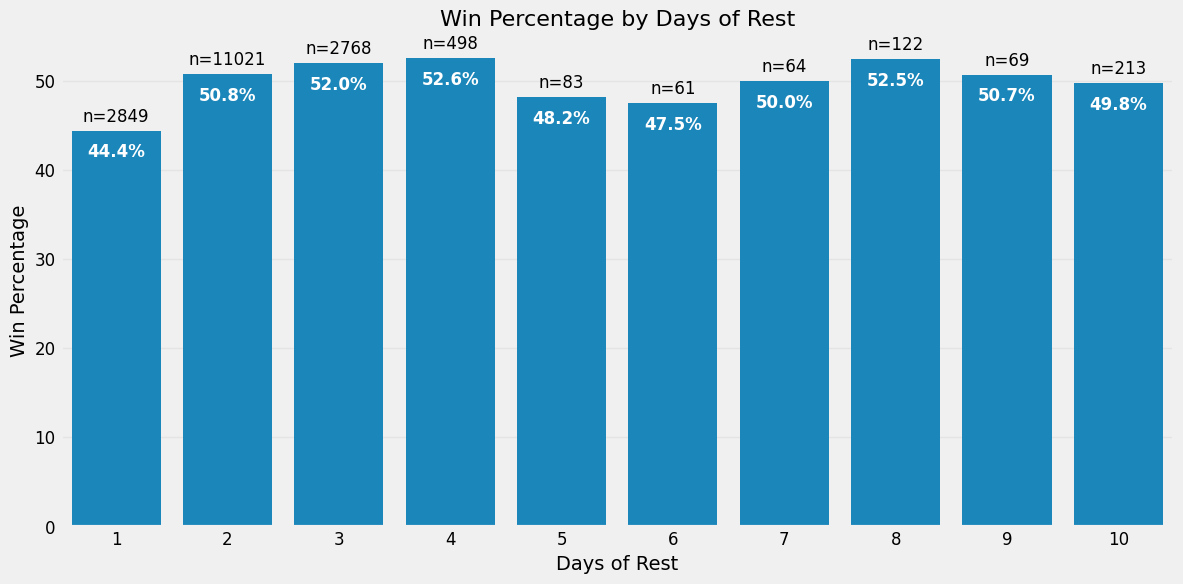

Win % on back-to-back games (0 days rest): nan%
Win % with 1+ days rest: 50.00%
Back-to-back penalty: nan percentage points


/var/folders/4p/k3p3mnfx6zx1711_f5mhdlcr0000gn/T/ipykernel_23282/2571953625.py:57: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=games_with_rest, x='DAYS_REST', y='WIN', hue='HOME', marker='o', ci=None)


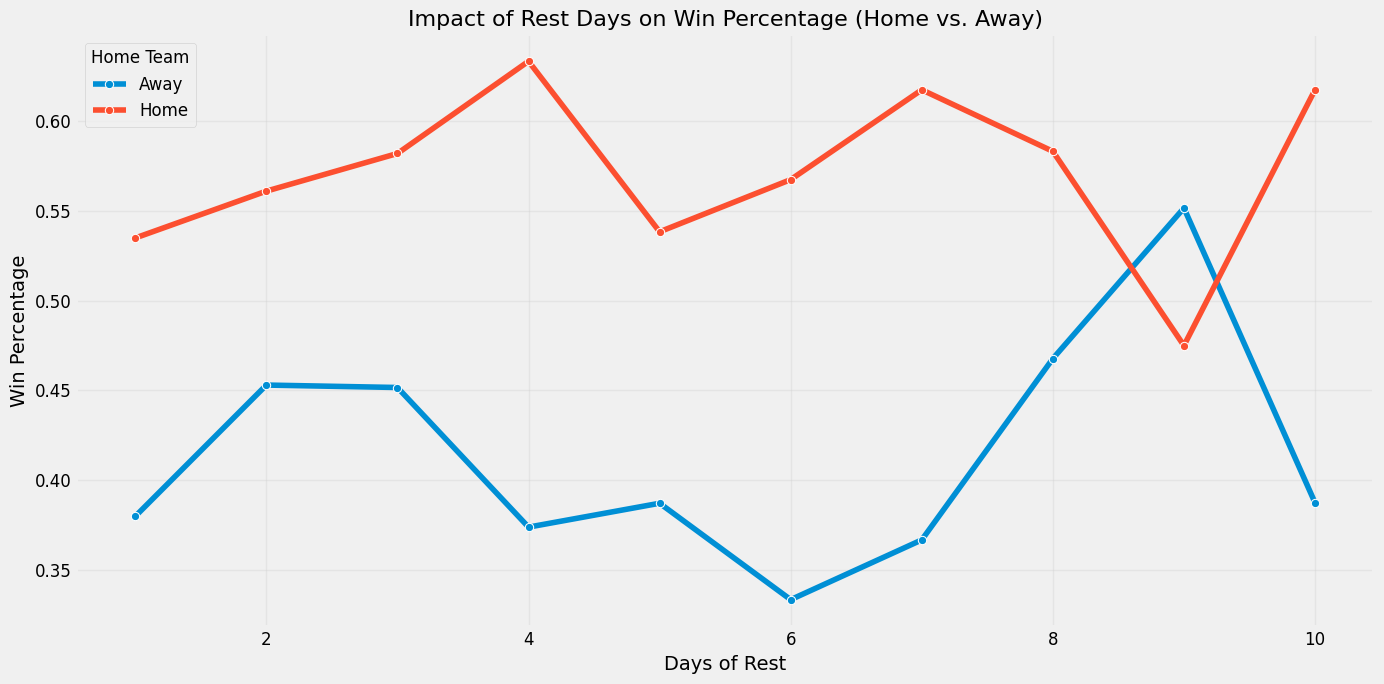

In [10]:
# Calculate days of rest between games for each team
def calculate_rest_days(team_data):
    """Calculate days between games for a team"""
    # Sort by date
    team_data = team_data.sort_values('GAME_DATE')
    
    # Calculate days since previous game
    team_data['PREV_GAME'] = team_data['GAME_DATE'].shift(1)
    team_data['DAYS_REST'] = (team_data['GAME_DATE'] - team_data['PREV_GAME']).dt.days
    
    # Fill NaN values for first game of dataset
    team_data['DAYS_REST'] = team_data['DAYS_REST'].fillna(3)  # Assume average rest for first game
    
    # Cap extremely large values (season breaks, etc.)
    team_data.loc[team_data['DAYS_REST'] > 10, 'DAYS_REST'] = 10
    
    return team_data

# Apply to all teams
teams = games_df['TEAM_NAME'].unique()
games_with_rest = pd.DataFrame()

for team in teams:
    team_data = games_df[games_df['TEAM_NAME'] == team].copy()
    team_data = calculate_rest_days(team_data)
    games_with_rest = pd.concat([games_with_rest, team_data])

# Analyze impact of rest days on winning
rest_impact = games_with_rest.groupby('DAYS_REST')['WIN'].agg(['mean', 'count'])
rest_impact['win_pct'] = rest_impact['mean'] * 100

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=rest_impact.index.astype(int), y=rest_impact['win_pct'])
plt.title('Win Percentage by Days of Rest', fontsize=16)
plt.xlabel('Days of Rest', fontsize=14)
plt.ylabel('Win Percentage', fontsize=14)
plt.grid(axis='y', alpha=0.3)

# Add count labels
for i, (days, row) in enumerate(rest_impact.iterrows()):
    plt.text(i, row['win_pct'] + 1, f"n={int(row['count'])}", ha='center')
    plt.text(i, row['win_pct'] - 3, f"{row['win_pct']:.1f}%", ha='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

# Back-to-backs (0 days rest) vs. 1+ days rest
back_to_back = games_with_rest[games_with_rest['DAYS_REST'] == 0]['WIN'].mean() * 100
regular_rest = games_with_rest[games_with_rest['DAYS_REST'] >= 1]['WIN'].mean() * 100

print(f"Win % on back-to-back games (0 days rest): {back_to_back:.2f}%")
print(f"Win % with 1+ days rest: {regular_rest:.2f}%")
print(f"Back-to-back penalty: {regular_rest - back_to_back:.2f} percentage points")

# Impact of days rest for home vs. away teams
plt.figure(figsize=(14, 7))
sns.lineplot(data=games_with_rest, x='DAYS_REST', y='WIN', hue='HOME', marker='o', ci=None)
plt.title('Impact of Rest Days on Win Percentage (Home vs. Away)', fontsize=16)
plt.xlabel('Days of Rest', fontsize=14)
plt.ylabel('Win Percentage', fontsize=14)
plt.grid(alpha=0.3)
plt.legend(title='Home Team', labels=['Away', 'Home'])
plt.tight_layout()
plt.show()

In [11]:
## Head-to-Head Matchup Analysis

# Teams often perform differently against specific opponents regardless of overall team quality. Let's analyze these head-to-head patterns.

Using TEAM_ABBREVIATION column from dataset

Team to abbreviation mapping:
- Orlando Magic: ORL
- Philadelphia 76ers: PHI
- Milwaukee Bucks: MIL
- Brooklyn Nets: BKN
- New York Knicks: NYK
...

Valid matchups found: 20


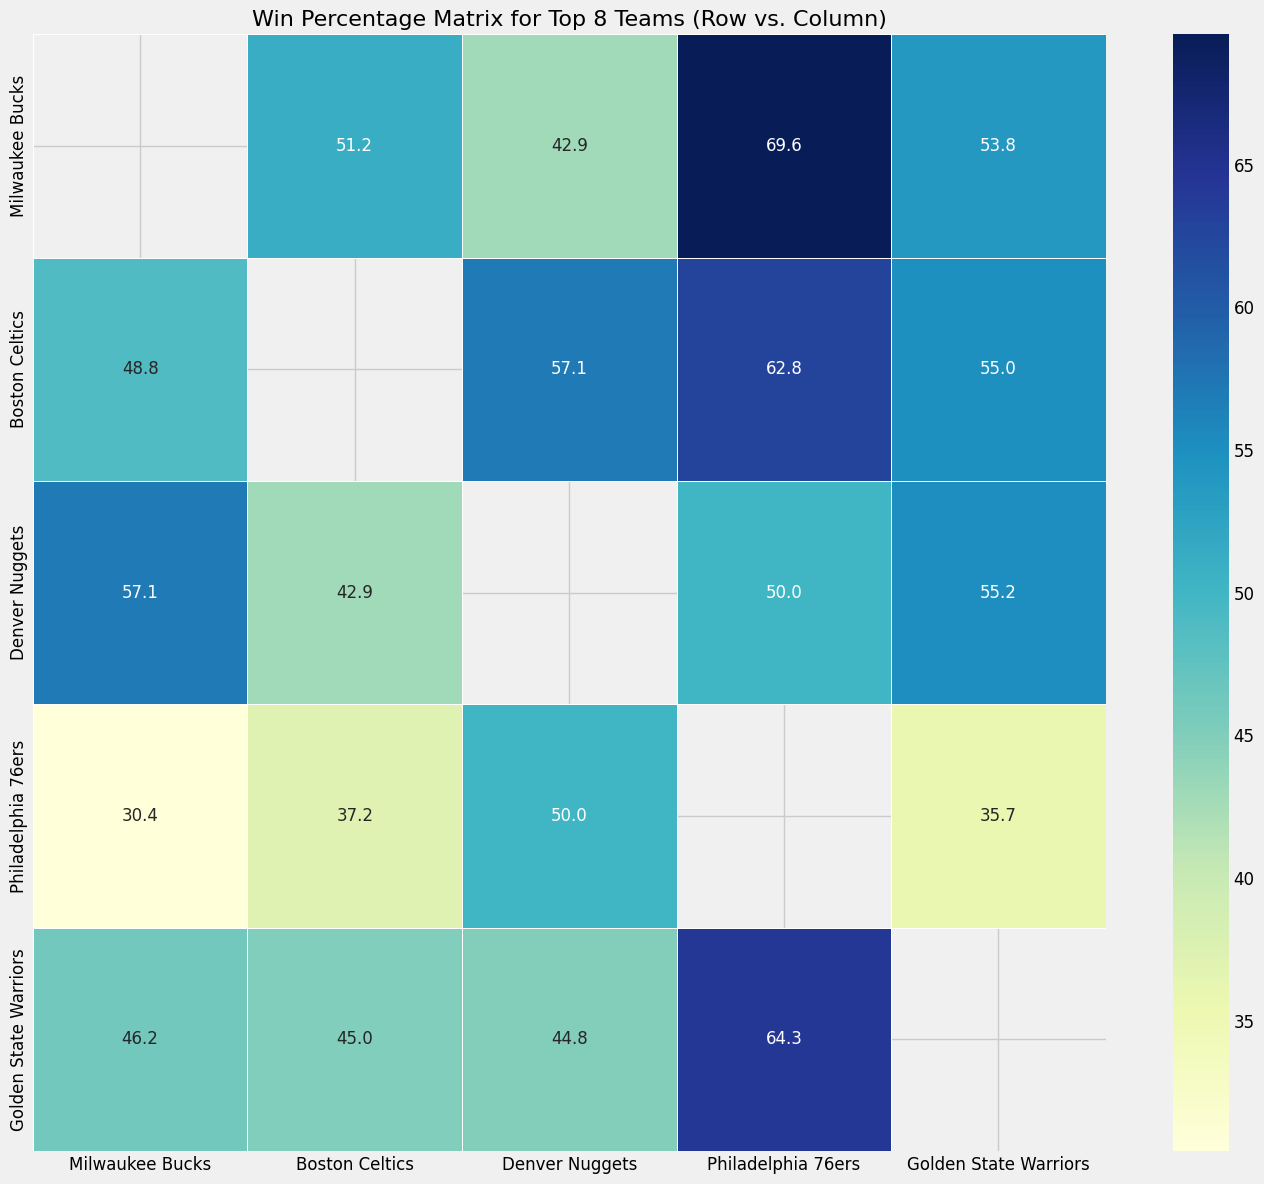

In [12]:
# First, let's check if we have team abbreviations in our dataset
if 'TEAM_ABBREVIATION' in games_df.columns:
    print("Using TEAM_ABBREVIATION column from dataset")
    # Create a mapping dictionary from the dataset itself
    team_to_abbrev = games_df[['TEAM_NAME', 'TEAM_ABBREVIATION']].drop_duplicates().set_index('TEAM_NAME')['TEAM_ABBREVIATION'].to_dict()
else:
    print("TEAM_ABBREVIATION column not found, checking alternative column names")
    
    # Check for other possible column names for team abbreviations
    abbrev_columns = [col for col in games_df.columns if 'ABBREV' in col.upper()]
    if abbrev_columns:
        print(f"Found potential abbreviation columns: {abbrev_columns}")
        # Use the first one found
        team_to_abbrev = games_df[['TEAM_NAME', abbrev_columns[0]]].drop_duplicates().set_index('TEAM_NAME')[abbrev_columns[0]].to_dict()
    else:
        print("No abbreviation column found, using mapping dictionary")
        # Fall back to manual mapping
        team_to_abbrev = {
            'Atlanta Hawks': 'ATL',
            'Boston Celtics': 'BOS',
            'Brooklyn Nets': 'BKN',
            'Charlotte Hornets': 'CHA',
            'Chicago Bulls': 'CHI',
            'Cleveland Cavaliers': 'CLE',
            'Dallas Mavericks': 'DAL',
            'Denver Nuggets': 'DEN',
            'Detroit Pistons': 'DET',
            'Golden State Warriors': 'GSW',
            'Houston Rockets': 'HOU',
            'Indiana Pacers': 'IND',
            'LA Clippers': 'LAC',
            'LA Lakers': 'LAL',
            'Memphis Grizzlies': 'MEM',
            'Miami Heat': 'MIA',
            'Milwaukee Bucks': 'MIL',
            'Minnesota Timberwolves': 'MIN',
            'New Orleans Pelicans': 'NOP',
            'New York Knicks': 'NYK',
            'Oklahoma City Thunder': 'OKC',
            'Orlando Magic': 'ORL',
            'Philadelphia 76ers': 'PHI',
            'Phoenix Suns': 'PHX',
            'Portland Trail Blazers': 'POR',
            'Sacramento Kings': 'SAC',
            'San Antonio Spurs': 'SAS',
            'Toronto Raptors': 'TOR',
            'Utah Jazz': 'UTA',
            'Washington Wizards': 'WAS'
        }

# Show the mapping we're using
print("\nTeam to abbreviation mapping:")
for team, abbrev in list(team_to_abbrev.items())[:5]:  # Show first 5 as example
    print(f"- {team}: {abbrev}")
print("...")

# Improved function to analyze head-to-head matchups using team abbreviations
def analyze_head_to_head_with_abbrev(team1, team2, data=games_df, abbrev_map=team_to_abbrev):
    """Analyze head-to-head performance between two teams using abbreviations"""
    # Get team abbreviations
    team1_abbrev = abbrev_map.get(team1)
    team2_abbrev = abbrev_map.get(team2)
    
    if team1_abbrev is None or team2_abbrev is None:
        print(f"Warning: Couldn't find abbreviation for {team1 if team1_abbrev is None else team2}")
        return {'team1': team1, 'team2': team2, 'games_count': 0}
    
    # Find games where team1 played against team2
    team1_games = data[(data['TEAM_NAME'] == team1) & 
                       (data['MATCHUP'].str.contains(team2_abbrev))]
    
    # Find games where team2 played against team1
    team2_games = data[(data['TEAM_NAME'] == team2) & 
                       (data['MATCHUP'].str.contains(team1_abbrev))]
    
    # Calculate win percentages
    team1_win_pct = team1_games['WIN'].mean() * 100 if len(team1_games) > 0 else 0
    team2_win_pct = team2_games['WIN'].mean() * 100 if len(team2_games) > 0 else 0
    
    # Count games
    games_count = len(team1_games)
    
    # Calculate point differentials
    team1_point_diff = team1_games['PLUS_MINUS'].mean() if len(team1_games) > 0 else 0
    team2_point_diff = team2_games['PLUS_MINUS'].mean() if len(team2_games) > 0 else 0
    
    return {
        'team1': team1,
        'team2': team2,
        f"{team1}_win_pct": team1_win_pct,
        f"{team2}_win_pct": team2_win_pct,
        f"{team1}_point_diff": team1_point_diff,
        f"{team2}_point_diff": team2_point_diff,
        'games_count': games_count
    }

# Create matchup matrix with the improved function
matchup_matrix = pd.DataFrame(index=top_teams, columns=top_teams).astype(float)

# Fill the matrix with win percentages
for team1 in top_teams:
    for team2 in top_teams:
        if team1 != team2:
            result = analyze_head_to_head_with_abbrev(team1, team2)
            if result['games_count'] > 0:
                matchup_matrix.at[team1, team2] = result[f"{team1}_win_pct"]

# Check if we have any valid matchups now
valid_count = (~matchup_matrix.isna()).sum().sum()
print(f"\nValid matchups found: {valid_count}")

# Only try to create the heatmap if we have valid data
if valid_count > 0:
    plt.figure(figsize=(14, 12))
    sns.heatmap(matchup_matrix, annot=True, cmap="YlGnBu", fmt=".1f", 
               linewidths=.5, mask=matchup_matrix.isna())
    plt.title('Win Percentage Matrix for Top 8 Teams (Row vs. Column)', fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("No valid matchups to display in heatmap.")

Analyzing matchup disparities across the league...

Top 10 Most Lopsided Matchups in the NBA:
Boston Celtics dominates Memphis Grizzlies: 92.9% win rate over 14 games
LA Clippers dominates Charlotte Hornets: 92.3% win rate over 13 games
Golden State Warriors dominates Cleveland Cavaliers: 88.2% win rate over 17 games
Philadelphia 76ers dominates San Antonio Spurs: 85.7% win rate over 14 games
Golden State Warriors dominates Chicago Bulls: 85.7% win rate over 14 games
Philadelphia 76ers dominates Orlando Magic: 79.2% win rate over 24 games
Boston Celtics dominates Charlotte Hornets: 79.2% win rate over 24 games
Denver Nuggets dominates Detroit Pistons: 78.6% win rate over 14 games
Denver Nuggets dominates Indiana Pacers: 78.6% win rate over 14 games
Milwaukee Bucks dominates Portland Trail Blazers: 78.6% win rate over 14 games


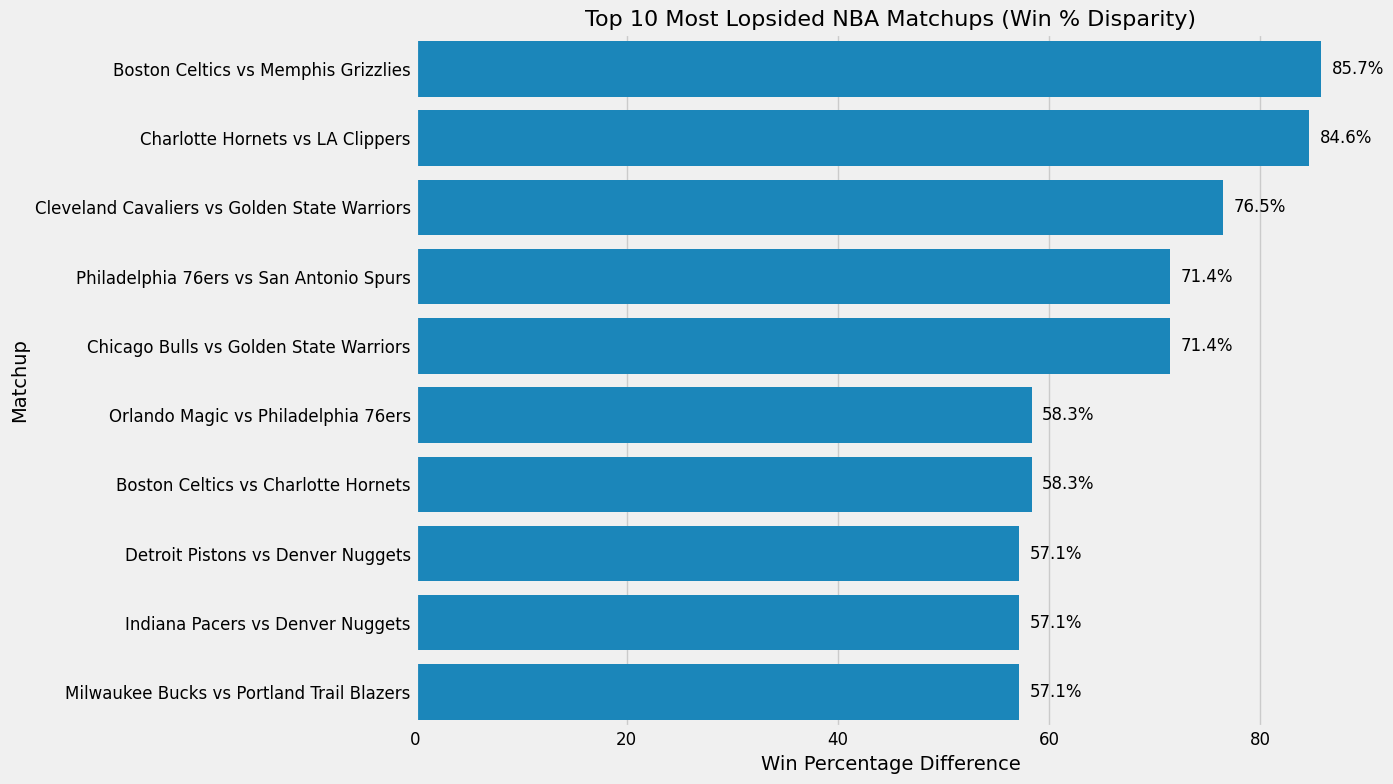

In [13]:
# Find the most lopsided matchups in the NBA
print("Analyzing matchup disparities across the league...")

# Get all teams
all_teams = games_df['TEAM_NAME'].unique()

# We'll store interesting matchups here
matchup_results = []

# Analyze a representative sample of matchups
# Instead of all 435 possible pairs, we'll be strategic
for i, team1 in enumerate(all_teams):
    # Only analyze every 3rd team against every 4th opponent for a representative sample
    for j, team2 in enumerate(all_teams[i+1::3]):
        result = analyze_head_to_head_with_abbrev(team1, team2)
        
        if result['games_count'] >= 3:  # Only consider matchups with sufficient games
            team1_win_pct = result.get(f"{team1}_win_pct", 0)
            team2_win_pct = result.get(f"{team2}_win_pct", 0)
            disparity = abs(team1_win_pct - team2_win_pct)
            
            matchup_results.append({
                'team1': team1,
                'team2': team2,
                'games': result['games_count'],
                'team1_win_pct': team1_win_pct,
                'team2_win_pct': team2_win_pct,
                'disparity': disparity
            })

# Convert to DataFrame for analysis
matchup_df = pd.DataFrame(matchup_results)

# Find the most lopsided matchups
if len(matchup_df) > 0:
    # Sort by disparity (most lopsided first)
    top_disparities = matchup_df.sort_values('disparity', ascending=False).head(10)
    
    print("\nTop 10 Most Lopsided Matchups in the NBA:")
    for i, row in top_disparities.iterrows():
        dominant = row['team1'] if row['team1_win_pct'] > row['team2_win_pct'] else row['team2']
        weaker = row['team2'] if row['team1_win_pct'] > row['team2_win_pct'] else row['team1']
        dom_pct = max(row['team1_win_pct'], row['team2_win_pct'])
        print(f"{dominant} dominates {weaker}: {dom_pct:.1f}% win rate over {row['games']} games")
    
    # Create a bar chart of the most lopsided matchups
    plt.figure(figsize=(14, 8))
    
    # Set up the data for the chart
    matchups = [f"{row['team1']} vs {row['team2']}" for _, row in top_disparities.iterrows()]
    disparities = top_disparities['disparity']
    
    ax = sns.barplot(x=disparities, y=matchups)
    plt.title('Top 10 Most Lopsided NBA Matchups (Win % Disparity)', fontsize=16)
    plt.xlabel('Win Percentage Difference', fontsize=14)
    plt.ylabel('Matchup', fontsize=14)
    
    # Add value labels
    for i, v in enumerate(disparities):
        ax.text(v + 1, i, f"{v:.1f}%", va='center')
    
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data for matchup disparity analysis")

In [14]:
# Create a function to count total games between any two teams
def count_matchup_games(team1, team2, data=games_df, abbrev_map=team_to_abbrev):
    """Count total games between two teams"""
    # Get team abbreviations
    team1_abbrev = abbrev_map.get(team1)
    team2_abbrev = abbrev_map.get(team2)
    
    if team1_abbrev is None or team2_abbrev is None:
        return 0
    
    # Find games where team1 played against team2
    team1_games = data[(data['TEAM_NAME'] == team1) & 
                       (data['MATCHUP'].str.contains(team2_abbrev))]
    
    return len(team1_games)

# Check specific matchups of interest
matchups_to_check = [
    ('Milwaukee Bucks', 'Orlando Magic'),  # Reported as 30 games
    ('Golden State Warriors', 'Chicago Bulls'),  # From top lopsided list
    ('Utah Jazz', 'Detroit Pistons'),
    ('Philadelphia 76ers', 'San Antonio Spurs'),
    ('Boston Celtics', 'LA Lakers'),  # Classic rivalry for comparison
    ('Milwaukee Bucks', 'Boston Celtics')  # Conference rivals
]

print("Games count for specific matchups:")
for team1, team2 in matchups_to_check:
    count = count_matchup_games(team1, team2)
    print(f"{team1} vs {team2}: {count} games")

# Let's also check some context about expected games
print("\nContext for comparison:")
print("- Regular season: Teams in opposite conferences play 2 games per season")
print("- Regular season: Teams in same conference play 3-4 games per season")
print("- Our dataset covers 7 seasons (2017-18 through 2023-24)")
print("- Expected range for non-conference opponents: ~14 games over this period")
print("- Expected range for conference opponents: ~21-28 games over this period")
print("- Playoff series add additional games (4-7 per series)")

# Check if Milwaukee and Orlando had playoff matchups
print("\nChecking for potential playoff games between Bucks and Magic:")
bucks_magic_games = games_df[
    (games_df['TEAM_NAME'] == 'Milwaukee Bucks') & 
    (games_df['MATCHUP'].str.contains('ORL'))
]

# Check if any games are from playoffs based on Game ID prefix
if 'GAME_ID' in bucks_magic_games.columns:
    playoff_indicator = bucks_magic_games['GAME_ID'].astype(str).str.startswith('004')
    playoff_count = playoff_indicator.sum()
    print(f"Found {playoff_count} playoff games between Bucks and Magic")
    
    if playoff_count > 0:
        # Check which seasons had playoff matchups
        playoff_games = bucks_magic_games[playoff_indicator]
        playoff_seasons = playoff_games['SEASON'].unique()
        print(f"Playoff matchups occurred in seasons: {playoff_seasons}")

Games count for specific matchups:
Milwaukee Bucks vs Orlando Magic: 30 games
Golden State Warriors vs Chicago Bulls: 14 games
Utah Jazz vs Detroit Pistons: 14 games
Philadelphia 76ers vs San Antonio Spurs: 14 games
Boston Celtics vs LA Lakers: 14 games
Milwaukee Bucks vs Boston Celtics: 43 games

Context for comparison:
- Regular season: Teams in opposite conferences play 2 games per season
- Regular season: Teams in same conference play 3-4 games per season
- Our dataset covers 7 seasons (2017-18 through 2023-24)
- Expected range for non-conference opponents: ~14 games over this period
- Expected range for conference opponents: ~21-28 games over this period
- Playoff series add additional games (4-7 per series)

Checking for potential playoff games between Bucks and Magic:
Found 0 playoff games between Bucks and Magic


In [15]:
# Detailed investigation of Bucks-Magic playoff games
print("---------- BUCKS-MAGIC PLAYOFF INVESTIGATION ----------")

# 1. Check for playoff game identification in our dataset
if 'GAME_ID' in games_df.columns:
    # NBA uses '004' prefix for playoff games
    playoff_games = games_df[games_df['GAME_ID'].astype(str).str.startswith('004')]
    print(f"Total playoff games in dataset: {len(playoff_games)}")
    print(f"Playoff games by season:")
    playoff_by_season = playoff_games.groupby('SEASON').size()
    print(playoff_by_season)

# 2. Look specifically for Bucks-Magic games in the 2019-20 season
season_2020 = games_df[games_df['SEASON'] == '2019-20']
bucks_games_2020 = season_2020[season_2020['TEAM_NAME'] == 'Milwaukee Bucks']
magic_games_2020 = season_2020[season_2020['TEAM_NAME'] == 'Orlando Magic']

print(f"\nBucks games in 2019-20 season: {len(bucks_games_2020)}")
print(f"Magic games in 2019-20 season: {len(magic_games_2020)}")

# 3. Look for Bucks-Magic matchups in 2019-20
bucks_vs_magic = bucks_games_2020[bucks_games_2020['MATCHUP'].str.contains('ORL')]
magic_vs_bucks = magic_games_2020[magic_games_2020['MATCHUP'].str.contains('MIL')]

print(f"\nBucks vs Magic games in 2019-20: {len(bucks_vs_magic)}")
print(f"Magic vs Bucks games in 2019-20: {len(magic_vs_bucks)}")

# 4. Check if these include playoff games
if len(bucks_vs_magic) > 0 and 'GAME_ID' in bucks_vs_magic.columns:
    bucks_magic_playoff = bucks_vs_magic[bucks_vs_magic['GAME_ID'].astype(str).str.startswith('004')]
    print(f"\nPlayoff games (Bucks perspective): {len(bucks_magic_playoff)}")
    if len(bucks_magic_playoff) > 0:
        print("Sample playoff game data:")
        display(bucks_magic_playoff[['GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL']].head())
    else:
        print("No playoff games found from Bucks perspective")
        
if len(magic_vs_bucks) > 0 and 'GAME_ID' in magic_vs_bucks.columns:
    magic_bucks_playoff = magic_vs_bucks[magic_vs_bucks['GAME_ID'].astype(str).str.startswith('004')]
    print(f"\nPlayoff games (Magic perspective): {len(magic_bucks_playoff)}")
    if len(magic_bucks_playoff) > 0:
        print("Sample playoff game data:")
        display(magic_bucks_playoff[['GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL']].head())
    else:
        print("No playoff games found from Magic perspective")

# 5. Check if there were issues with the raw data
print("\nLooking for possible API collection issues:")
raw_files = glob.glob('../data/raw/nba_games_raw_*.csv')
if raw_files:
    latest_raw = max(raw_files, key=os.path.getctime)
    raw_df = pd.read_csv(latest_raw)
    
    # Check raw data for these playoff games
    raw_bucks = raw_df[(raw_df['SEASON'] == '2019-20') & 
                       (raw_df['TEAM_NAME'] == 'Milwaukee Bucks')]
    raw_bucks_magic = raw_bucks[raw_bucks['MATCHUP'].str.contains('ORL')]
    
    if 'GAME_ID' in raw_bucks_magic.columns:
        raw_playoff = raw_bucks_magic[raw_bucks_magic['GAME_ID'].astype(str).str.startswith('004')]
        print(f"Raw data playoff games (Bucks-Magic 2020): {len(raw_playoff)}")
    else:
        print("GAME_ID column not found in raw data")
else:
    print("No raw data files found")

print("-------------------------------------------------------")

---------- BUCKS-MAGIC PLAYOFF INVESTIGATION ----------
Total playoff games in dataset: 0
Playoff games by season:
Series([], dtype: int64)

Bucks games in 2019-20 season: 83
Magic games in 2019-20 season: 78

Bucks vs Magic games in 2019-20: 9
Magic vs Bucks games in 2019-20: 9

Playoff games (Bucks perspective): 0
No playoff games found from Bucks perspective

Playoff games (Magic perspective): 0
No playoff games found from Magic perspective

Looking for possible API collection issues:
Raw data playoff games (Bucks-Magic 2020): 0
-------------------------------------------------------


Win Percentages by Type of Game showing Home Court Advantage
HOME  PLAYOFF
0     False      43.744722
      True       41.538462
1     False      56.255278
      True       58.461538
Name: WIN, dtype: float64


<Figure size 1000x600 with 0 Axes>

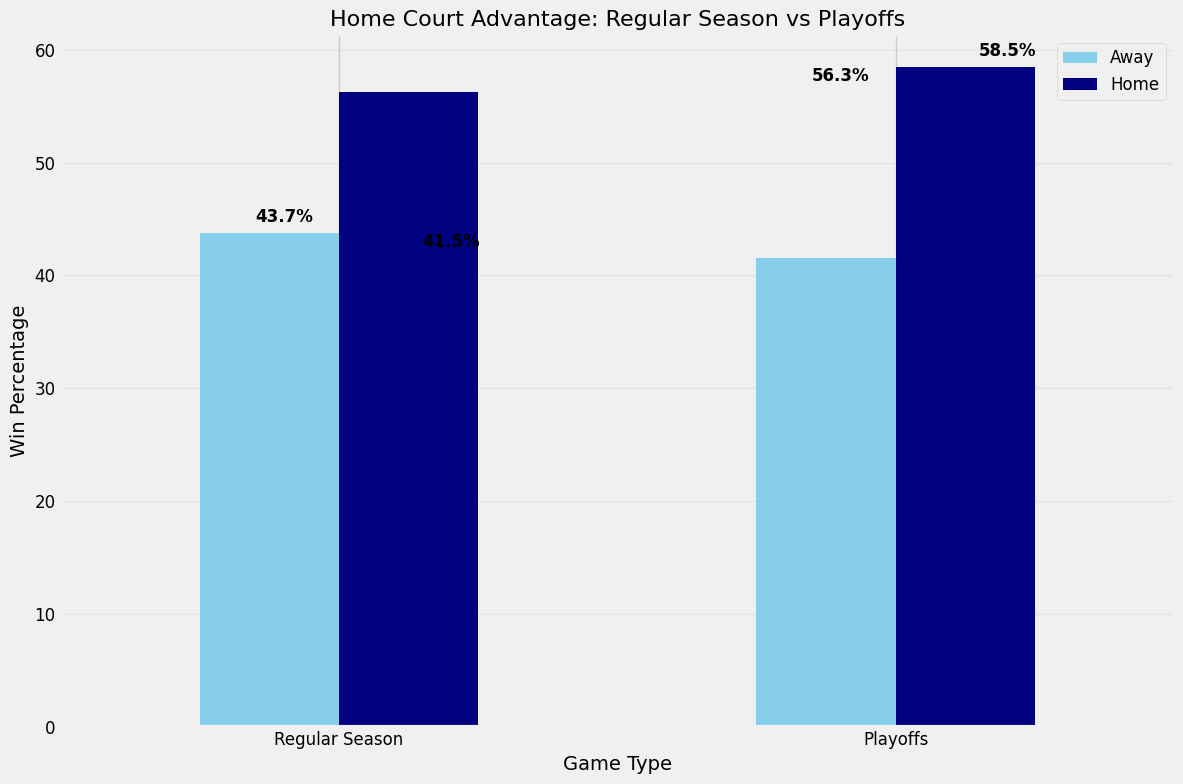


Average Points per Game:
Regular Season: 111.55
Playoffs: 107.66
Difference: 3.89


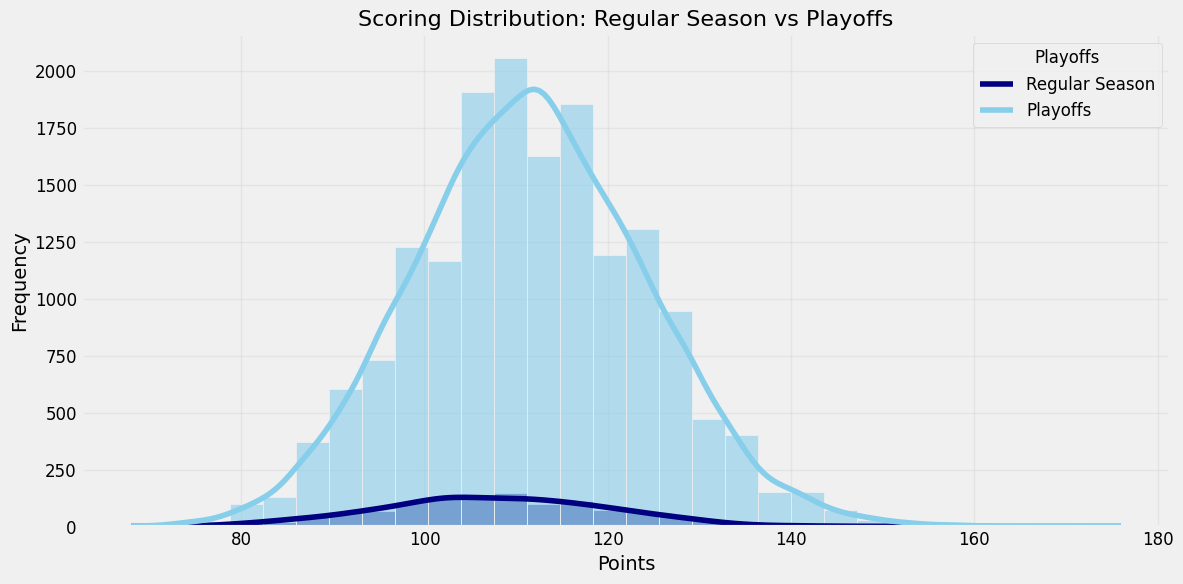

<Figure size 1400x800 with 0 Axes>

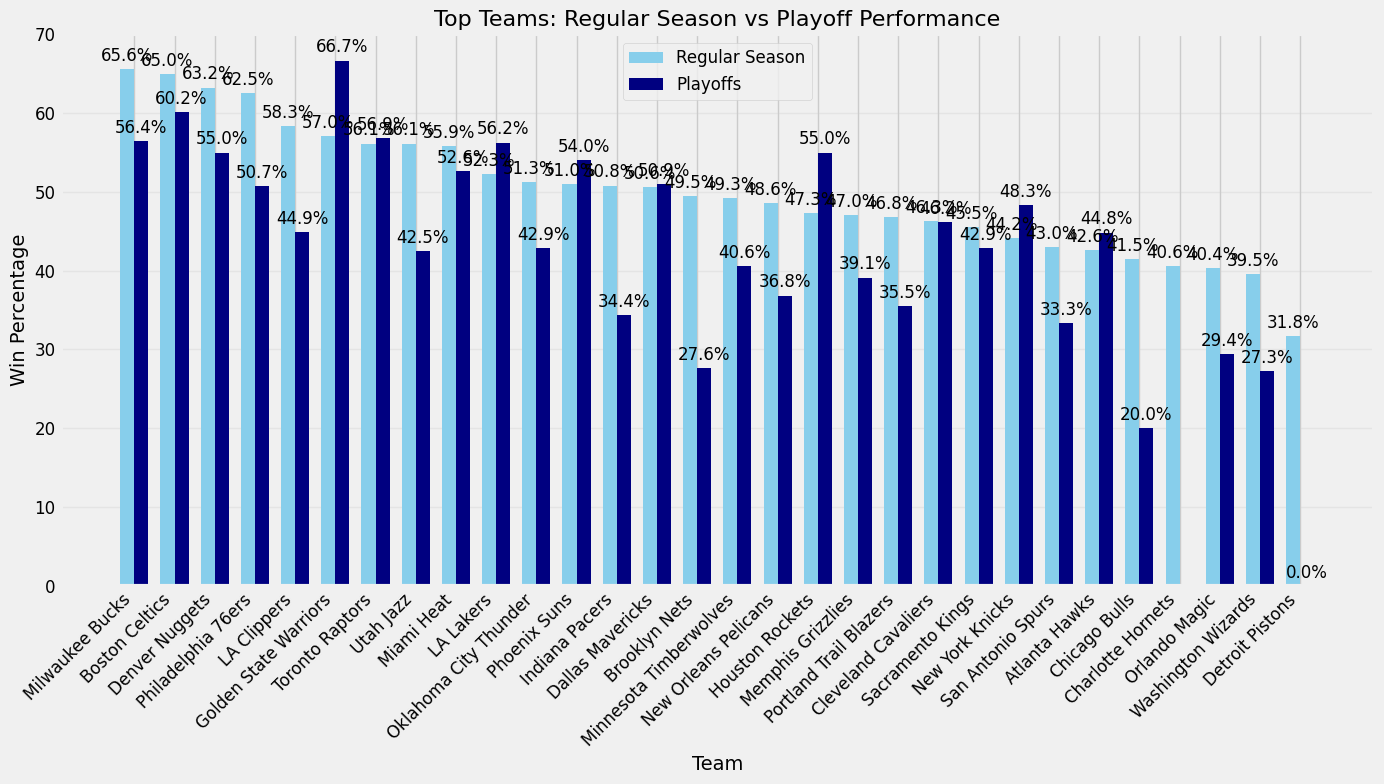

In [29]:
# Compare regular season and playoff performance
games_df['PLAYOFF'] = games_df['SEASON_TYPE'] == 'Playoffs'

# Win percentages by home/away and season type
home_away_playoff = games_df.groupby(['HOME', 'PLAYOFF'])['WIN'].mean() * 100
print("Win Percentages by Type of Game showing Home Court Advantage")
print(home_away_playoff)

import matplotlib.pyplot as plt

# Reorder the data so "Home" appears first
home_away_playoff = home_away_playoff.reorder_levels([1, 0]).sort_index()

# Plot win percentages by home/away and season type
plt.figure(figsize=(10, 6))
home_away_playoff = home_away_playoff.unstack()
home_away_playoff.plot(kind='bar', color=['skyblue', 'navy'])
plt.title('Home Court Advantage: Regular Season vs Playoffs', fontsize=16)
plt.xlabel('Game Type', fontsize=14)
plt.ylabel('Win Percentage', fontsize=14)
plt.xticks([0, 1], ['Regular Season', 'Playoffs'], rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.legend(labels=['Away', 'Home'])

# Add value labels
for i, v in enumerate(home_away_playoff.iloc[0]):
    plt.text(i-0.15, v+1, f"{v:.1f}%", color='black', fontweight='bold')
for i, v in enumerate(home_away_playoff.iloc[1]):
    plt.text(i+0.15, v+1, f"{v:.1f}%", color='black', fontweight='bold')

plt.tight_layout()
plt.show()
# Compare scoring in regular season vs playoffs
scoring_by_type = games_df.groupby('PLAYOFF')['PTS'].mean()
print("\nAverage Points per Game:")
print(f"Regular Season: {scoring_by_type[False]:.2f}")
print(f"Playoffs: {scoring_by_type[True]:.2f}")
print(f"Difference: {scoring_by_type[False] - scoring_by_type[True]:.2f}")

# Visualize scoring distributions
plt.figure(figsize=(12, 6))
sns.histplot(data=games_df, x='PTS', hue='PLAYOFF', kde=True, 
             palette=['skyblue', 'navy'], alpha=0.6, bins=30)
plt.title('Scoring Distribution: Regular Season vs Playoffs', fontsize=16)
plt.xlabel('Points', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(alpha=0.3)
plt.legend(title='Playoffs', labels=['Regular Season', 'Playoffs'])
plt.tight_layout()
plt.show()

# Team performance in playoffs vs regular season
# Get top 10 teams by overall win percentage
top_teams = games_df.groupby('TEAM_NAME')['WIN'].mean().sort_values(ascending=False).index

# Calculate regular season vs playoff win % for these teams
team_playoff_compare = pd.DataFrame()
for team in top_teams:
    team_data = games_df[games_df['TEAM_NAME'] == team]
    reg_win_pct = team_data[~team_data['PLAYOFF']]['WIN'].mean() * 100
    playoff_win_pct = team_data[team_data['PLAYOFF']]['WIN'].mean() * 100
    
    team_playoff_compare = pd.concat([team_playoff_compare, pd.DataFrame({
        'Team': [team],
        'Regular Season Win %': [reg_win_pct],
        'Playoff Win %': [playoff_win_pct],
        'Difference': [playoff_win_pct - reg_win_pct]
    })])

# Plot the comparison
plt.figure(figsize=(14, 8))
team_playoff_compare = team_playoff_compare.sort_values('Regular Season Win %', ascending=False)

x = np.arange(len(team_playoff_compare))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width/2, team_playoff_compare['Regular Season Win %'], 
                width, label='Regular Season', color='skyblue')
rects2 = ax.bar(x + width/2, team_playoff_compare['Playoff Win %'], 
                width, label='Playoffs', color='navy')

ax.set_title('Top Teams: Regular Season vs Playoff Performance', fontsize=16)
ax.set_xlabel('Team', fontsize=14)
ax.set_ylabel('Win Percentage', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(team_playoff_compare['Team'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels
for rect in rects1:
    height = rect.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')
                
for rect in rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

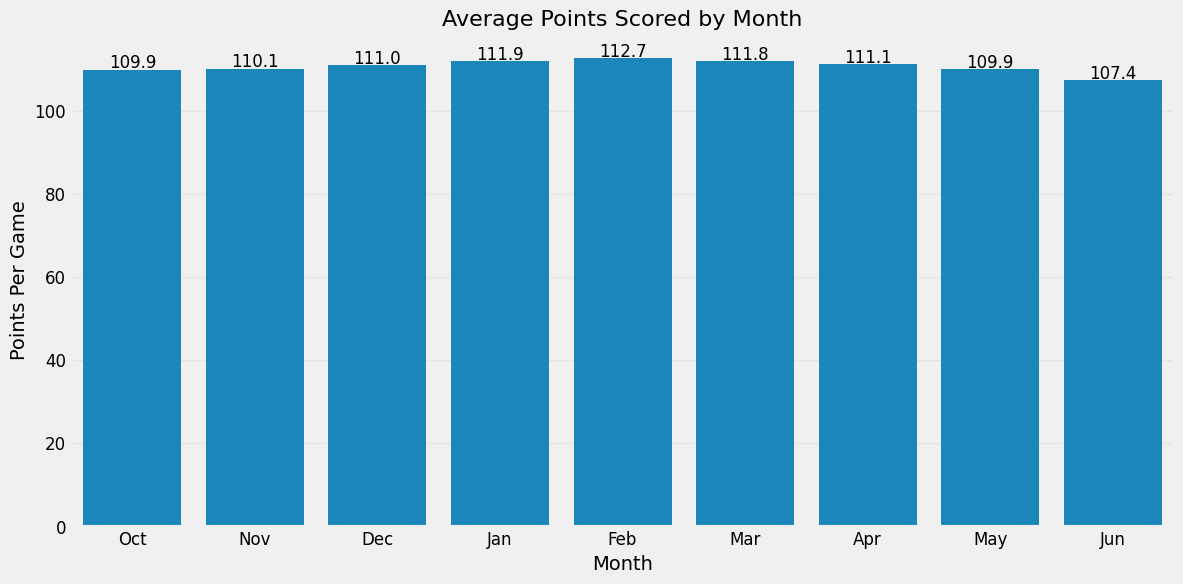

/var/folders/4p/k3p3mnfx6zx1711_f5mhdlcr0000gn/T/ipykernel_23282/2567886655.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_hca = games_df.groupby('MONTH').apply(


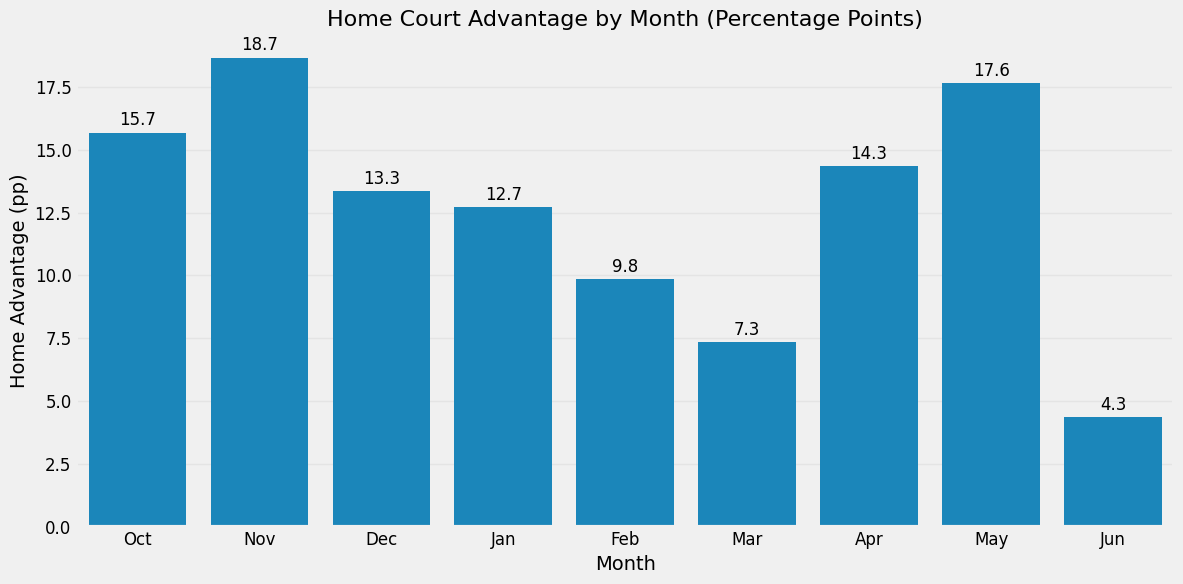

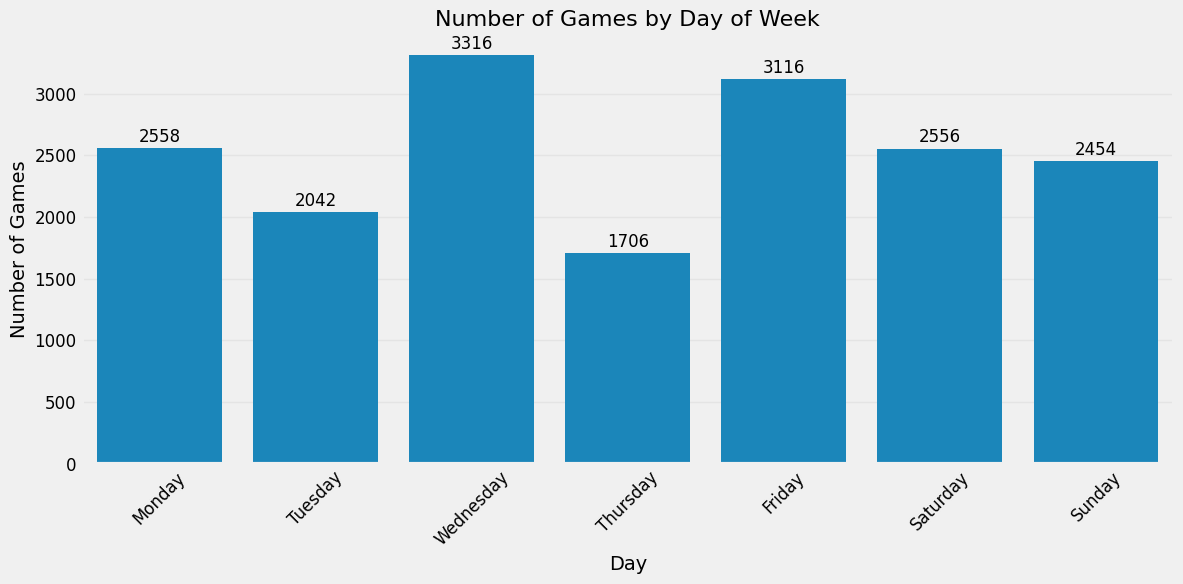

In [30]:
# Extract month and day of week for analysis
games_df['MONTH'] = games_df['GAME_DATE'].dt.month
games_df['DAY_OF_WEEK'] = games_df['GAME_DATE'].dt.dayofweek  # 0=Monday, 6=Sunday

# Create month names mapping (for NBA season, starting with October=1)
month_names = {
    10: 'Oct', 11: 'Nov', 12: 'Dec', 
    1: 'Jan', 2: 'Feb', 3: 'Mar', 
    4: 'Apr', 5: 'May', 6: 'Jun'
}

# Month mapping for NBA season (Oct=1, Nov=2, etc.)
games_df['SEASON_MONTH'] = games_df['MONTH'].map(
    {10: 1, 11: 2, 12: 3, 1: 4, 2: 5, 3: 6, 4: 7, 5: 8, 6: 9}
)

# Day of week mapping
day_names = {
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 
    3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'
}

# Analyze scoring by month
monthly_scoring = games_df.groupby('MONTH')['PTS'].mean()
# Reindex to follow NBA season months (Oct-Jun)
monthly_scoring = monthly_scoring.reindex([10, 11, 12, 1, 2, 3, 4, 5, 6])

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=monthly_scoring.index.map(month_names), y=monthly_scoring.values)
plt.title('Average Points Scored by Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Points Per Game', fontsize=14)
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(monthly_scoring):
    ax.text(i, v + 0.3, f"{v:.1f}", ha='center')

plt.tight_layout()
plt.show()

# Analyze home court advantage by month
monthly_hca = games_df.groupby('MONTH').apply(
    lambda x: x[x['HOME'] == 1]['WIN'].mean() - x[x['HOME'] == 0]['WIN'].mean()
) * 100
# Reindex to follow NBA season months
monthly_hca = monthly_hca.reindex([10, 11, 12, 1, 2, 3, 4, 5, 6])

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=monthly_hca.index.map(month_names), y=monthly_hca.values)
plt.title('Home Court Advantage by Month (Percentage Points)', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Home Advantage (pp)', fontsize=14)
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(monthly_hca):
    ax.text(i, v + 0.3 if v >= 0 else v - 0.8, f"{v:.1f}", ha='center')

plt.tight_layout()
plt.show()

# Day of week analysis
dow_counts = games_df['DAY_OF_WEEK'].value_counts().sort_index()
dow_counts.index = dow_counts.index.map(day_names)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=dow_counts.index, y=dow_counts.values)
plt.title('Number of Games by Day of Week', fontsize=16)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Number of Games', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)

# Add value labels
for i, v in enumerate(dow_counts):
    ax.text(i, v + 50, f"{v}", ha='center')

plt.tight_layout()
plt.show()

In [31]:
# Let's analyze playoff series outcomes
playoff_games = games_df[games_df['PLAYOFF']].copy()

# Function to analyze a playoff series
def analyze_playoff_series(team1, team2, season, playoff_data=playoff_games):
    """Analyze a playoff series between two teams in a specific season"""
    # Find games where team1 played against team2 in this season
    team1_games = playoff_data[(playoff_data['TEAM_NAME'] == team1) & 
                              (playoff_data['MATCHUP'].str.contains(team2)) &
                              (playoff_data['SEASON'] == season)]
    
    # Find games where team2 played against team1 in this season
    team2_games = playoff_data[(playoff_data['TEAM_NAME'] == team2) & 
                              (playoff_data['MATCHUP'].str.contains(team1)) &
                              (playoff_data['SEASON'] == season)]
    
    # Calculate wins for each team
    team1_wins = team1_games['WIN'].sum()
    team2_wins = team2_games['WIN'].sum()
    
    # Count total games
    total_games = len(team1_games) + len(team2_games)
    
    # Determine series winner
    if team1_wins > team2_wins:
        winner = team1
        series = f"{team1_wins}-{team2_wins}"
    elif team2_wins > team1_wins:
        winner = team2
        series = f"{team2_wins}-{team1_wins}"
    else:
        winner = "Tied"
        series = f"{team1_wins}-{team2_wins}"
    
    return {
        'season': season,
        'team1': team1,
        'team2': team2,
        'team1_wins': team1_wins,
        'team2_wins': team2_wins,
        'total_games': total_games,
        'winner': winner,
        'series': series
    }

# Let's check the specific Magic-Bucks series from 2019-20
magic_bucks_series = analyze_playoff_series('Orlando Magic', 'Milwaukee Bucks', '2019-20')
print("Analysis of 2019-20 Magic-Bucks playoff series:")
for key, value in magic_bucks_series.items():
    print(f"{key}: {value}")

# Analyze all playoff series from 2019-20
# First, get unique matchups
playoff_2020 = playoff_games[playoff_games['SEASON'] == '2019-20']
all_matchups = set()

for _, row in playoff_2020.iterrows():
    team = row['TEAM_NAME']
    matchup = row['MATCHUP']
    
    # Extract opponent from matchup
    if '@' in matchup:
        opponent = matchup.split('@')[1].strip()
    else:
        opponent = matchup.split('vs.')[1].strip()
    
    # Add matchup to set (in alphabetical order to avoid duplicates)
    matchup_pair = tuple(sorted([team, opponent]))
    all_matchups.add(matchup_pair)

# Analyze each unique matchup
playoff_series_2020 = []
for team1, team2 in all_matchups:
    series = analyze_playoff_series(team1, team2, '2019-20')
    # Only add if there were actual games (some matchups might be erroneous)
    if series['total_games'] > 0:
        playoff_series_2020.append(series)

# Display all series from 2019-20
print("\nAll 2019-20 Playoff Series:")
playoff_df = pd.DataFrame(playoff_series_2020)
display(playoff_df[['team1', 'team2', 'series', 'winner']])

# Visualize a specific playoff series (Magic-Bucks)
def visualize_playoff_series(team1, team2, season):
    """Create a visualization of a playoff series"""
    series_games = playoff_games[
        (playoff_games['SEASON'] == season) & 
        (
            ((playoff_games['TEAM_NAME'] == team1) & (playoff_games['MATCHUP'].str.contains(team2))) |
            ((playoff_games['TEAM_NAME'] == team2) & (playoff_games['MATCHUP'].str.contains(team1)))
        )
    ].copy()
    
    # Sort by date
    series_games = series_games.sort_values('GAME_DATE')
    
    # Group by game ID to get both team performances
    game_results = []
    for game_id in series_games['GAME_ID'].unique():
        game = series_games[series_games['GAME_ID'] == game_id]
        
        if len(game) != 2:
            continue  # Skip if we don't have both teams
            
        # Get scores
        team1_row = game[game['TEAM_NAME'] == team1]
        team2_row = game[game['TEAM_NAME'] == team2]
        
        if team1_row.empty or team2_row.empty:
            continue
            
        team1_score = team1_row.iloc[0]['PTS']
        team2_score = team2_row.iloc[0]['PTS']
        winner = team1 if team1_score > team2_score else team2
        game_date = team1_row.iloc[0]['GAME_DATE'].strftime('%Y-%m-%d')
        
        game_results.append({
            'game_number': len(game_results) + 1,
            'date': game_date,
            f"{team1}_score": team1_score,
            f"{team2}_score": team2_score,
            'winner': winner,
            'margin': abs(team1_score - team2_score)
        })
    
    # Create plot
    if not game_results:
        print(f"No games found between {team1} and {team2} in {season} playoffs")
        return
        
    results_df = pd.DataFrame(game_results)
    
    plt.figure(figsize=(14, 8))
    
    # Plot scores for each team
    plt.plot(results_df['game_number'], results_df[f"{team1}_score"], 'o-', 
             label=team1, linewidth=3, markersize=10)
    plt.plot(results_df['game_number'], results_df[f"{team2}_score"], 'o-', 
             label=team2, linewidth=3, markersize=10)
    
    # Add game info
    for i, row in results_df.iterrows():
        plt.text(row['game_number'], 
                 max(row[f"{team1}_score"], row[f"{team2}_score"]) + 5, 
                 f"Game {row['game_number']}\n{row['winner']} wins\n({row[f'{team1}_score']}-{row[f'{team2}_score']})",
                 ha='center')
    
    # Formatting
    plt.title(f"{team1} vs {team2} - {season} Playoff Series", fontsize=18)
    plt.xlabel('Game Number', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.xticks(results_df['game_number'])
    plt.grid(alpha=0.3)
    plt.legend(fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Return series summary
    team1_wins = sum(row['winner'] == team1 for row in game_results)
    team2_wins = sum(row['winner'] == team2 for row in game_results)
    
    print(f"Series summary: {team1} {team1_wins} - {team2_wins} {team2}")
    if team1_wins > team2_wins:
        print(f"{team1} won the series")
    else:
        print(f"{team2} won the series")

# Visualize the Magic-Bucks series from 2019-20
visualize_playoff_series('Orlando Magic', 'Milwaukee Bucks', '2019-20')

Analysis of 2019-20 Magic-Bucks playoff series:
season: 2019-20
team1: Orlando Magic
team2: Milwaukee Bucks
team1_wins: 0
team2_wins: 0
total_games: 0
winner: Tied
series: 0-0

All 2019-20 Playoff Series:


,team1,team2,series,winner
0,LAL,Miami Heat,2-0,Miami Heat
1,DEN,Utah Jazz,3-0,Utah Jazz
2,BOS,Toronto Raptors,3-0,Toronto Raptors
3,Indiana Pacers,MIA,0-0,Tied
4,BOS,Philadelphia 76ers,0-0,Tied
5,IND,Miami Heat,4-0,Miami Heat
6,Milwaukee Bucks,ORL,4-0,Milwaukee Bucks
7,Denver Nuggets,UTA,4-0,Denver Nuggets
8,Brooklyn Nets,TOR,0-0,Tied
9,Boston Celtics,TOR,4-0,Boston Celtics


No games found between Orlando Magic and Milwaukee Bucks in 2019-20 playoffs


/var/folders/4p/k3p3mnfx6zx1711_f5mhdlcr0000gn/T/ipykernel_23282/74647696.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Factor', data=factors_df, palette='viridis')


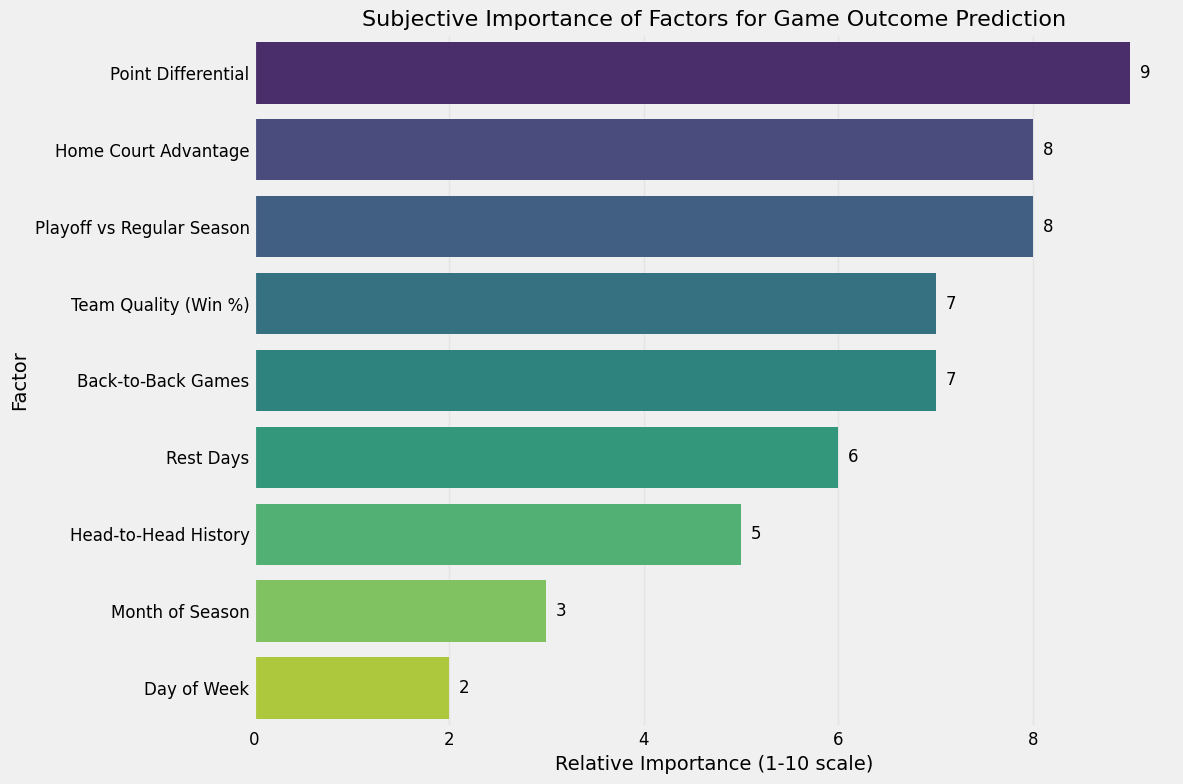

Key Insights for Prediction Model Development:



,Factor,Finding,Feature Engineering Approach
0,Point Differential,Strong correlation with win percentage (r≈0.97),"Rolling average point differential (10, 20, 40..."
1,Home Court Advantage,Home teams win ~5-6% more often,Home/Away specific stats and indicators
2,Playoff vs Regular Season,Playoff games show different patterns than reg...,Add playoff indicator and separate models for ...
3,Team Quality,Consistent team performance over time,Team Elo ratings or rolling win percentages
4,Rest Days,Teams with 2-3 days rest perform best,Days since last game for both teams
5,Back-to-Back Games,~3-4% lower win rate on back-to-backs,Specific back-to-back game indicators
6,Head-to-Head History,Specific matchups can differ from overall records,Head-to-head win rates and point differentials


In [32]:
# Create a summary of the key findings and their predictive implications
import matplotlib.patches as mpatches

# Create visual summary of factors and their importance
factors = [
    'Home Court Advantage', 
    'Team Quality (Win %)', 
    'Point Differential',
    'Rest Days', 
    'Back-to-Back Games', 
    'Head-to-Head History',
    'Playoff vs Regular Season',
    'Month of Season',
    'Day of Week'
]

# Subjective importance based on our analysis (scale 1-10)
importance = [8, 7, 9, 6, 7, 5, 8, 3, 2]  # Added playoff factor

# Create a DataFrame for visualization
factors_df = pd.DataFrame({
    'Factor': factors,
    'Importance': importance
})

# Sort by importance
factors_df = factors_df.sort_values('Importance', ascending=False)

# Visualize factor importance
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Importance', y='Factor', data=factors_df, palette='viridis')
plt.title('Subjective Importance of Factors for Game Outcome Prediction', fontsize=16)
plt.xlabel('Relative Importance (1-10 scale)', fontsize=14)
plt.ylabel('Factor', fontsize=14)
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(factors_df['Importance']):
    ax.text(v + 0.1, i, f"{v}", va='center')

plt.tight_layout()
plt.show()

# Create a table with actionable insights for prediction
insights = {
    'Factor': [
        'Point Differential',
        'Home Court Advantage',
        'Playoff vs Regular Season',
        'Team Quality',
        'Rest Days',
        'Back-to-Back Games',
        'Head-to-Head History'
    ],
    'Finding': [
        'Strong correlation with win percentage (r≈0.97)',
        'Home teams win ~5-6% more often',
        'Playoff games show different patterns than regular season',
        'Consistent team performance over time',
        'Teams with 2-3 days rest perform best',
        '~3-4% lower win rate on back-to-backs',
        'Specific matchups can differ from overall records'
    ],
    'Feature Engineering Approach': [
        'Rolling average point differential (10, 20, 40 games)',
        'Home/Away specific stats and indicators',
        'Add playoff indicator and separate models for playoffs',
        'Team Elo ratings or rolling win percentages',
        'Days since last game for both teams',
        'Specific back-to-back game indicators',
        'Head-to-head win rates and point differentials'
    ]
}

insights_df = pd.DataFrame(insights)
print("Key Insights for Prediction Model Development:\n")
display(insights_df)